In this notebook, we will benchmark LCEGP against LCEMGP to ensure everything works fine.

LCEMGP, as is defined, does not support fully categorical inputs. So, we will use 1
categorical and one continuous input, and see how the fitted models compare.

In [1]:
import torch
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple
from botorch import fit_gpytorch_model
from botorch.models.contextual_multioutput import LCEMGP
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from torch import Tensor
from contextual_rs.lce_gp import LCEGP

We will train both models on same training data and compare the resulting posterior.

In [2]:
K = 10  # number of alternatives

rho = 0.5
true_mean = torch.linspace(0, 1, K)
true_cov = torch.zeros(K, K)
for i in range(K):
    for j in range(K):
        true_cov[i, j] = torch.tensor(rho).pow(abs(i - j))
true_mvn = MultivariateNormal(true_mean, true_cov)


num_train = 50
cat_X = torch.arange(
    K, dtype=torch.float
).repeat(num_train).reshape(-1, 1)
cat_Y = true_mvn.rsample(torch.Size([num_train])).reshape(-1, 1).detach()

cont_X = torch.rand_like(cat_X)
cont_Y = torch.sin(10 * cont_X)

train_X = torch.cat([cat_X, cont_X], dim=-1)
train_Y = cat_Y * cont_Y

lcem = LCEMGP(train_X, train_Y, 0, embs_dim_list=[2])
mll = ExactMarginalLogLikelihood(lcem.likelihood, lcem)
%time fit_gpytorch_model(mll)

lce = LCEGP(train_X, train_Y, [0], embs_dim_list=[2])
mll = ExactMarginalLogLikelihood(lce.likelihood, lce)
%time fit_gpytorch_model(mll)

print("fit complete")

CPU times: user 19.4 s, sys: 17.3 s, total: 36.7 s
Wall time: 5.17 s
CPU times: user 1min 4s, sys: 57.4 s, total: 2min 1s
Wall time: 16.8 s
fit complete


Dummy posterior calls to ensure both models work.

In [3]:
post_m = lcem.posterior(X=torch.ones(1, 1)*0.1)

test_X = torch.arange(10, dtype=torch.float).reshape(-1, 1)
test_X = torch.cat([test_X, torch.ones_like(test_X)*0.1], dim=-1)
post = lce.posterior(test_X)

print(f"LCE mean: {post.mean.view(-1)}, \n "
      f"LCEM mean: {post_m.mean.view(-1)}, \n"
      f"true mean: {true_mean.view(-1) * torch.sin(torch.tensor(1.0))}.")

LCE mean: tensor([0.0369, 0.1361, 0.3865, 0.2851, 0.2377, 0.2647, 0.3066, 0.3259, 0.3419,
        0.4358], grad_fn=<ViewBackward>), 
 LCEM mean: tensor([0.0801, 0.0383, 0.3715, 0.3038, 0.2616, 0.2884, 0.2907, 0.3068, 0.3154,
        0.3791], grad_fn=<ViewBackward>), 
true mean: tensor([0.0000, 0.0935, 0.1870, 0.2805, 0.3740, 0.4675, 0.5610, 0.6545, 0.7480,
        0.8415]).


Let's plot the sample means for all alternatives.

The blue lines are the LCEMGP, orange are LCEGP and the green is the true function.
LCEMGP and LCEGP mostly agree, which is nice.

In [4]:
cont_X = torch.linspace(0, 1, 100).reshape(-1, 1)

post_m = lcem.posterior(cont_X).mean.detach()

cat_X = torch.arange(K, dtype=torch.float).reshape(-1, 1)
test_X = torch.cat(
    [
        cat_X.expand(cont_X.shape[0], -1, -1),
        cont_X.unsqueeze(-2).expand(-1, *cat_X.shape),
    ], dim=-1
)
post = lce.posterior(test_X).mean.squeeze(-1).detach()

true_vals = true_mean.detach() * torch.sin(cont_X*10)

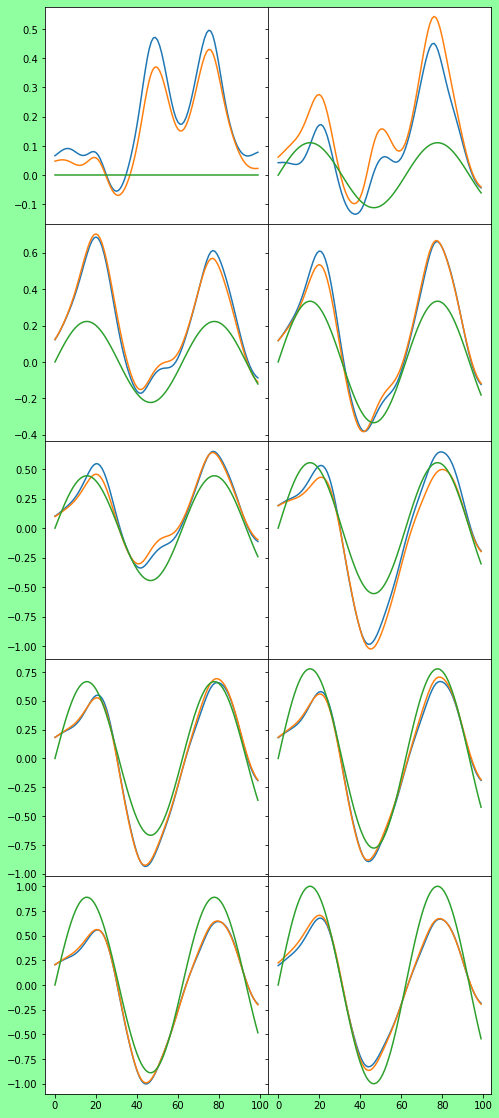

In [5]:
fig = plt.figure(figsize=(8, 20))
gs = fig.add_gridspec(5, 2, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')
# fig,ax = plt.subplots(5, 2)
fig.patch.set_facecolor('xkcd:mint green')

for i in range(10):
    c_ax = ax[i//2, i%2]
    c_ax.plot(post_m[:, i])
    c_ax.plot(post[:, i])
    c_ax.plot(true_vals[:, i])


Compare the posterior covariances. The values below suggest that they're close enough.

In [11]:
cont_X = torch.tensor([[0.5]])
cat_X = torch.arange(K, dtype=torch.float).reshape(-1, 1)

test_X = torch.cat(
    [
        cat_X.expand(cont_X.shape[0], -1, -1),
        cont_X.unsqueeze(-2).expand(-1, *cat_X.shape),
    ], dim=-1
)

cov_m = lcem.posterior(cont_X).mvn.covariance_matrix
cov = lce.posterior(test_X.view(-1, 2)).mvn.covariance_matrix

print(f"lcem cov: {cov_m}")
print(f"lce cov: {cov}")

print(f"diff cov: {cov_m-cov}")

lcem cov: tensor([[ 4.1669e-02,  9.2872e-03,  1.0428e-02,  7.5415e-03,  9.0834e-03,
         -8.5706e-04, -7.9455e-04, -6.0008e-04, -8.3488e-04, -5.0335e-04],
        [ 9.2872e-03,  4.1666e-02, -7.2306e-04,  8.2197e-03,  1.2368e-02,
          2.5597e-03,  4.0329e-03,  3.9664e-03,  5.3033e-05, -5.2747e-04],
        [ 1.0428e-02, -7.2306e-04,  2.7388e-02,  1.6409e-02,  1.4133e-02,
          9.2421e-04,  2.2949e-03,  4.3041e-03,  1.9134e-03,  1.0273e-02],
        [ 7.5415e-03,  8.2197e-03,  1.6409e-02,  1.7146e-02,  1.7347e-02,
          4.3574e-03,  6.3622e-03,  7.8896e-03,  3.4693e-03,  8.9746e-03],
        [ 9.0834e-03,  1.2368e-02,  1.4133e-02,  1.7347e-02,  1.8531e-02,
          4.1174e-03,  6.2990e-03,  7.6283e-03,  2.5420e-03,  7.0877e-03],
        [-8.5706e-04,  2.5597e-03,  9.2421e-04,  4.3574e-03,  4.1174e-03,
          1.5694e-02,  1.4522e-02,  1.3312e-02,  1.5568e-02,  1.0818e-02],
        [-7.9455e-04,  4.0329e-03,  2.2949e-03,  6.3622e-03,  6.2990e-03,
          1.4522e-02, 

In [12]:
metric = 1 - (cov_m.matmul(cov)).trace() / (
        torch.linalg.norm(cov_m) * torch.linalg.norm(cov)
)
print(f"1-cosine metric: {metric}")


1-cosine metric: 0.06292909383773804
